In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

# Set path to test image folder
TEST_IMAGE_PATH = Path("../data")  # or wherever your images are

# List image files (filter common image formats)
image_files = [f for f in TEST_IMAGE_PATH.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

print(f"Found {len(image_files)} images in {TEST_IMAGE_PATH}")

# Display first few images
def show_test_images(images, n=5):
    plt.figure(figsize=(15, 3))
    for i, img_file in enumerate(images[:n]):
        img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(img_file.name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_test_images(image_files)


Normalizing


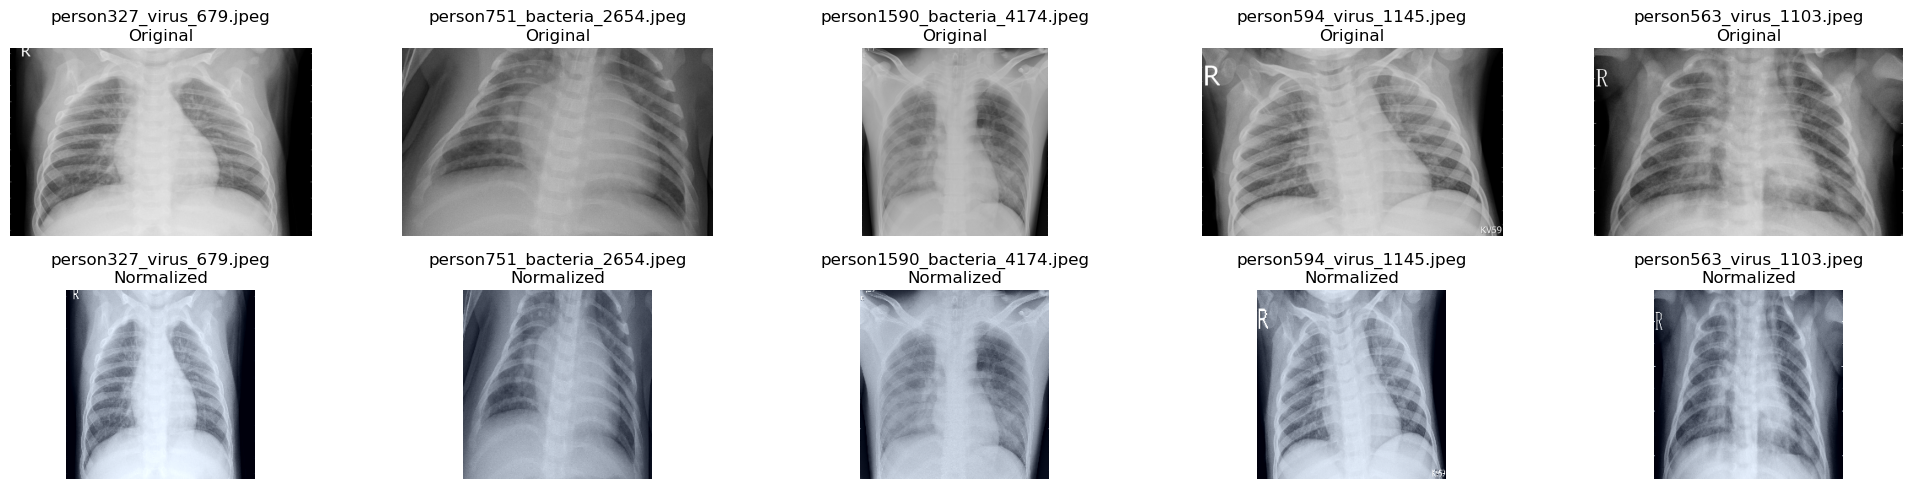

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Configurations
DATASET_PATH = Path("../data/train/normal")  # example folder: change as needed
IMAGE_SIZE = (224, 224)
# ImageNet normalization parameters
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def preprocess_image(img, method='imagenet'):
    """
    Preprocesses an image:
      - Converts from BGR to RGB.
      - Resizes to IMAGE_SIZE.
      - Scales to [0, 1].
      - Applies ImageNet normalization if method is 'imagenet'.
    Returns the raw normalized image.
    """
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize image
    img = cv2.resize(img, IMAGE_SIZE)
    # Scale to [0,1]
    img = img.astype(np.float32) / 255.0
    if method == 'imagenet':
        # Apply channel-wise normalization:
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
    return img

def display_normalized_image(normalized_img, method='imagenet'):
    """
    For display purposes only: maps the raw normalized image values to a [0, 1] range.
    For ImageNet normalization, we expect most values to be in approximately [-2, 2].
    This function clips values to [-2, 2] and rescales them to [0, 1].
    """
    if method == 'imagenet':
        disp = np.clip(normalized_img, -2, 2)
        # Map from [-2, 2] to [0, 1]
        disp = (disp + 2) / 4.0
        return disp
    else:
        # For other methods, simply clip between 0 and 1
        return np.clip(normalized_img, 0, 1)

def preview_raw_normalized_images(folder_path, method='imagenet', n=5):
    """
    Randomly selects 'n' images from folder_path, applies preprocessing (with normalization),
    and displays the raw normalized images (after mapping to [0,1] for visualization).
    """
    folder = Path(folder_path)
    image_files = list(folder.glob('*'))
    if not image_files:
        print(f"No images found in {folder_path}")
        return
    
    # Randomly select images
    random_images = random.sample(image_files, min(n, len(image_files)))
    
    plt.figure(figsize=(20, 5))  # Increase width for side-by-side images
    for i, img_path in enumerate(random_images):
        # Load original image in BGR
        original_img = cv2.imread(str(img_path))
        # Preprocess image: resize, convert to RGB, scale, and normalize
        norm_img = preprocess_image(original_img, method=method)
        # For display: remap the normalized values to [0,1]
        display_img = display_normalized_image(norm_img, method=method)
        
        # Show original image (before normalization)
        plt.subplot(2, n, i+1)  # 2 rows, n columns
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_path.name}\nOriginal")
        plt.axis('off')
        
        # Show normalized image (after normalization)
        plt.subplot(2, n, i+1+n)  # 2 rows, n columns
        plt.imshow(display_img)
        plt.title(f"{img_path.name}\nNormalized")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example: Preview original and normalized images from the "pneumonia" class in the train folder
preview_raw_normalized_images("../data/train/pneumonia", method='imagenet', n=5)


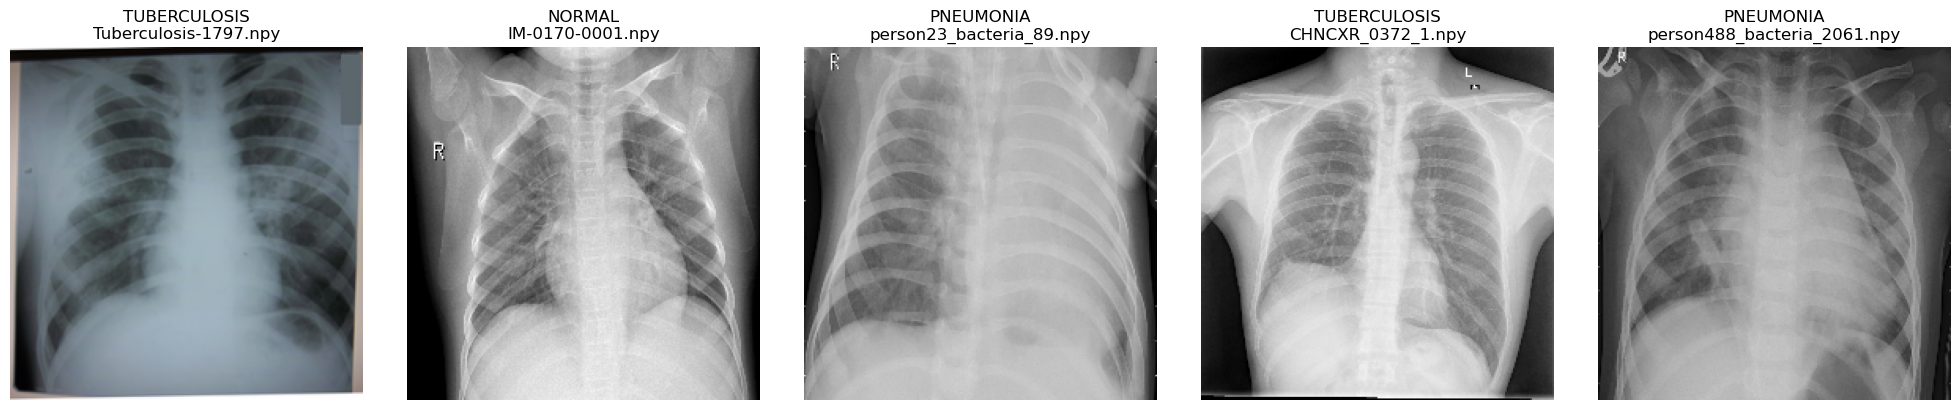

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# ImageNet normalization constants
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# Adjust path to point to your data_processed folder
DATA_PROCESSED_DIR = Path("../data_processed")  # Use relative to script location

def denormalize_image(img):
    """
    Reverses ImageNet normalization.
    """
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

def get_all_npy_files(base_dir):
    """
    Recursively get all .npy files from base_dir
    """
    return list(base_dir.rglob("*.npy"))

def display_random_npy_images(n=5):
    npy_files = get_all_npy_files(DATA_PROCESSED_DIR)
    if not npy_files:
        print("No .npy files found.")
        return

    selected_files = random.sample(npy_files, min(n, len(npy_files)))
    
    plt.figure(figsize=(20, 4))
    for i, file_path in enumerate(selected_files):
        norm_img = np.load(file_path)
        img = denormalize_image(norm_img)

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(file_path.parent.name + "\n" + file_path.name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    display_random_npy_images(n=5)


In [24]:
import numpy as np
import cv2
from pathlib import Path
import random

# Constants
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
DATA_PROCESSED_DIR = Path("../data_processed")   # relative to script in src/
IGNORE_DIR = Path("../ignore")                   # output location
IGNORE_DIR.mkdir(exist_ok=True)

def denormalize_image(img):
    """
    Reverses ImageNet normalization and converts to 0-255 uint8 format for saving.
    """
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

def pick_and_save_random_images(n=10):
    npy_files = list(DATA_PROCESSED_DIR.rglob("*.npy"))
    if len(npy_files) < n:
        print(f"Only found {len(npy_files)} images.")
        n = len(npy_files)

    selected_files = random.sample(npy_files, n)

    for i, file_path in enumerate(selected_files):
        norm_img = np.load(file_path)
        img = denormalize_image(norm_img)
        output_path = IGNORE_DIR / f"img_{i+1}_{file_path.parent.name}.jpg"
        # Convert RGB to BGR before saving with OpenCV
        cv2.imwrite(str(output_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    print(f"✅ Saved {n} images to: {IGNORE_DIR.resolve()}")

# Run it
if __name__ == "__main__":
    pick_and_save_random_images(10)


✅ Saved 10 images to: C:\Users\User\OneDrive\Documents\AUB\Courses\EECE 490\xray_diagnosis_ML\ignore
